### Denoicing time series data with $Fast\space Fourier\space Transform$

More often real world time series is very noisy. In somecases its better to have some way to get rid from those noisiness. To do that there are numerous ways, and here we will focus on on of ways to perform time series denoicing.

In [2]:
import pandas as pd 
import numpy as np
from prophet import Prophet
import warnings
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('../')
from helpers import tsplot,plot_predictions

mpl.rc('font',family='Serif')
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(1997)

In [4]:
df = pd.read_parquet('../creds and datasets/sample_10_000_preprocessed.parquet')
df.columns = ['uid','usage']

Let's select one random user and plot usage behaviour

In [5]:
user = 2352
sample_usage = df.query("uid==@user")['usage']

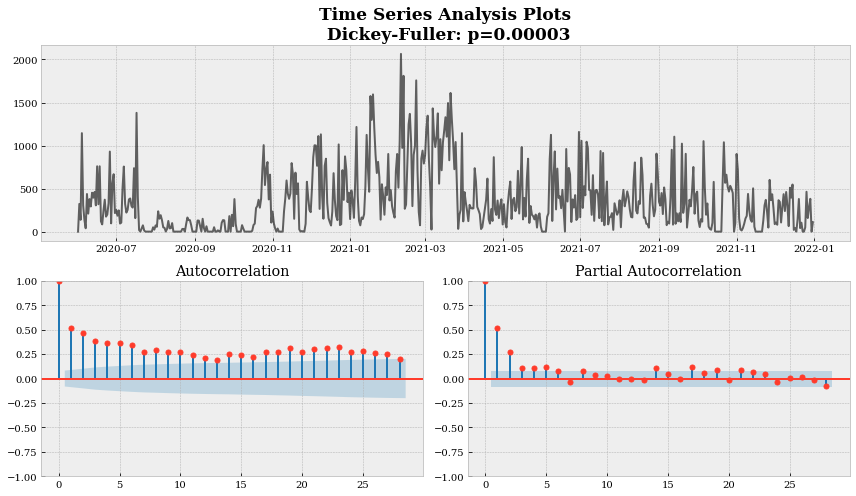

In [6]:
tsplot(sample_usage)

In [7]:
del df

Before applying any denoicing methds,let's make predictions using original data.

In [8]:
data = sample_usage.reset_index()
data.columns = ['ds','y']
data.head()

,ds,y
0,2020-06-01,0
1,2020-06-02,322
2,2020-06-03,137
3,2020-06-04,1144
4,2020-06-05,306


In [9]:
train = data.loc[0:549,:]
test = data.loc[550:,:]

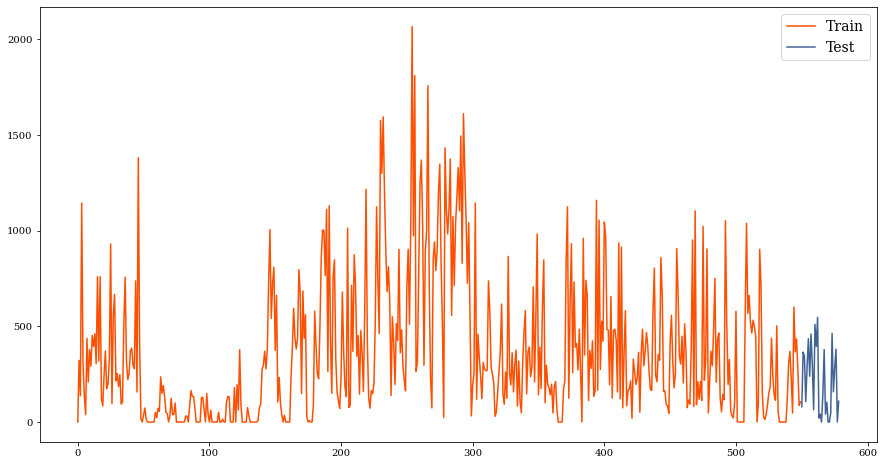

In [10]:
plt.figure(figsize=(15,8))
plt.plot(train['y'],color='#FF4F00',label='Train')
plt.plot(test['y'],color='#406395',label='Test')
plt.legend(loc='upper right',fontsize=14)
plt.show()

In [11]:
m = Prophet()
m.fit(train)

predictions = m.predict(test[['ds']])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


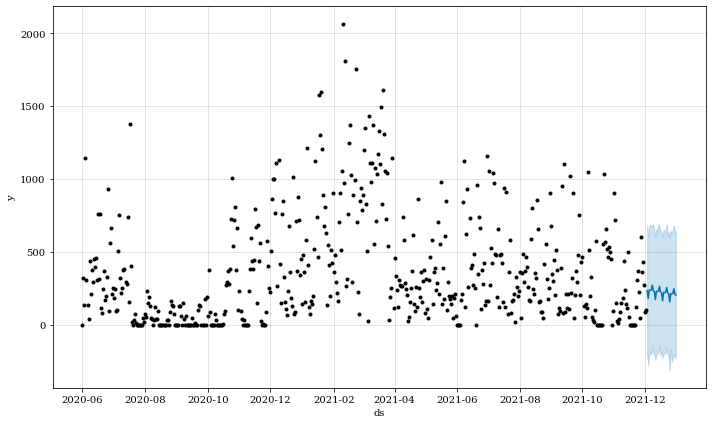

In [12]:
m.plot(predictions)
plt.show()

In [13]:
y = test.set_index('ds')['y']
yhat = predictions.set_index('ds')['yhat']

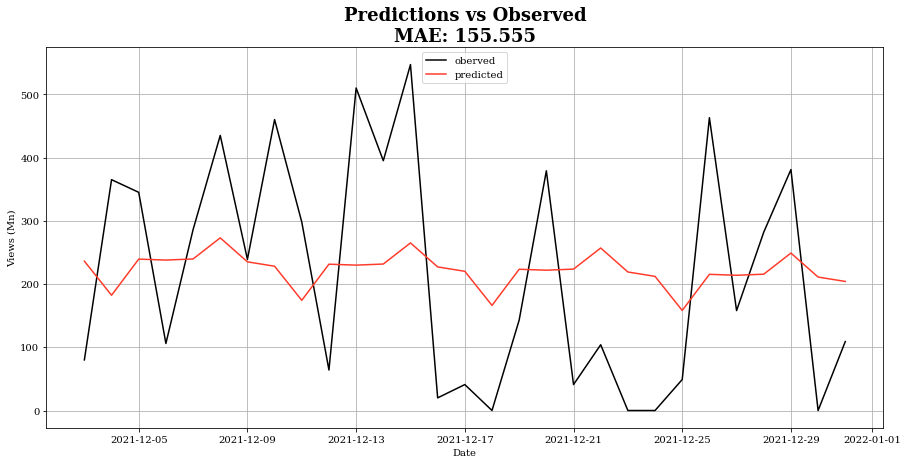

In [14]:
plot_predictions(y,yhat,metric='MAE')

Here MAPE value is little weired, because our original series has zero values.

Now time to apply $FFT$

In [15]:
from numpy.fft import rfft, irfft, rfftfreq

In [16]:
def low_pass(s, threshold=1e3):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2 / s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [17]:
def plot_fft(thresh):
    plt.figure(figsize=(15,8))
    lf_signal_1 = low_pass(train.iloc[:, 1],threshold=thresh)
    plt.plot(train.iloc[:, 1], color='lightgray')
    plt.plot(lf_signal_1, color='black')
    plt.title(f"FFT with threshold:{thresh:.1e}",fontweight='semibold')
    plt.show()

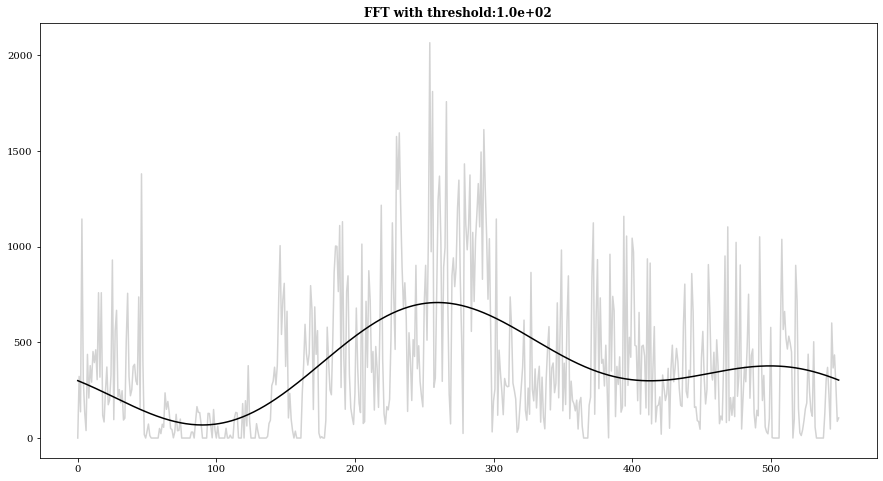

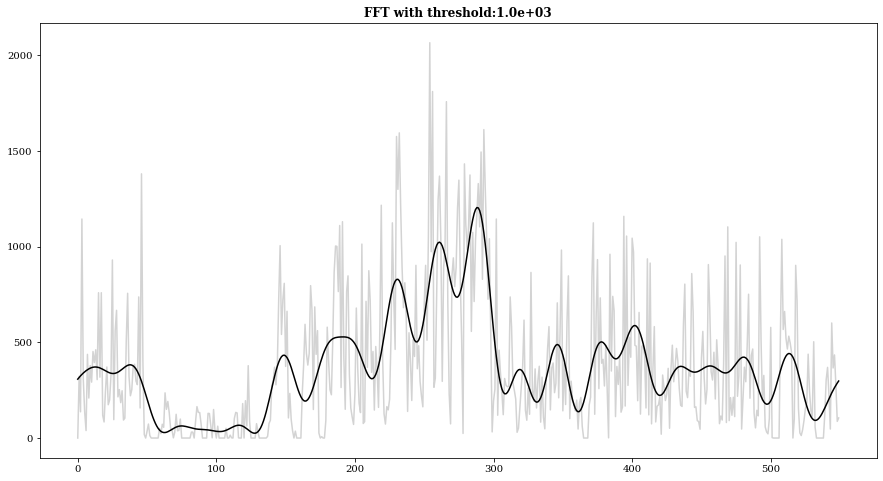

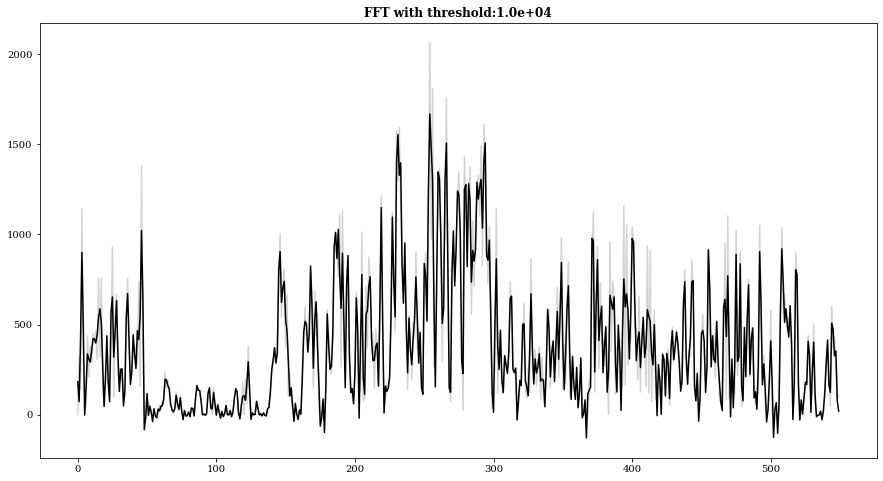

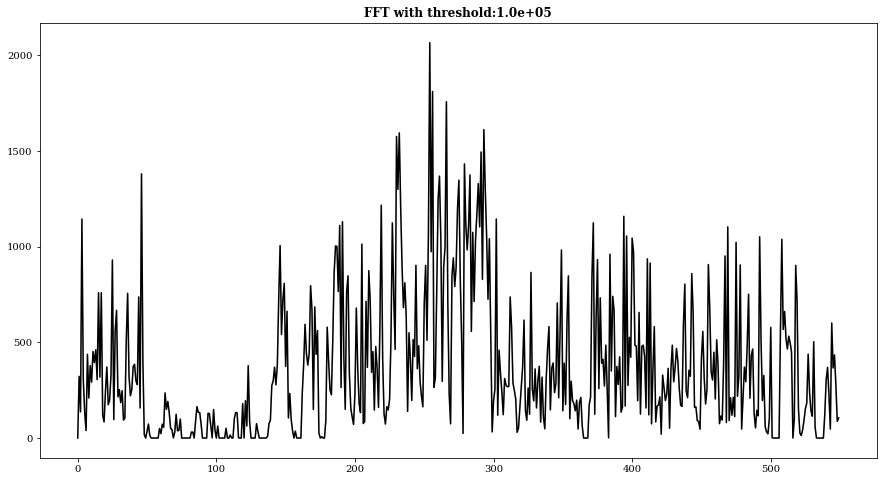

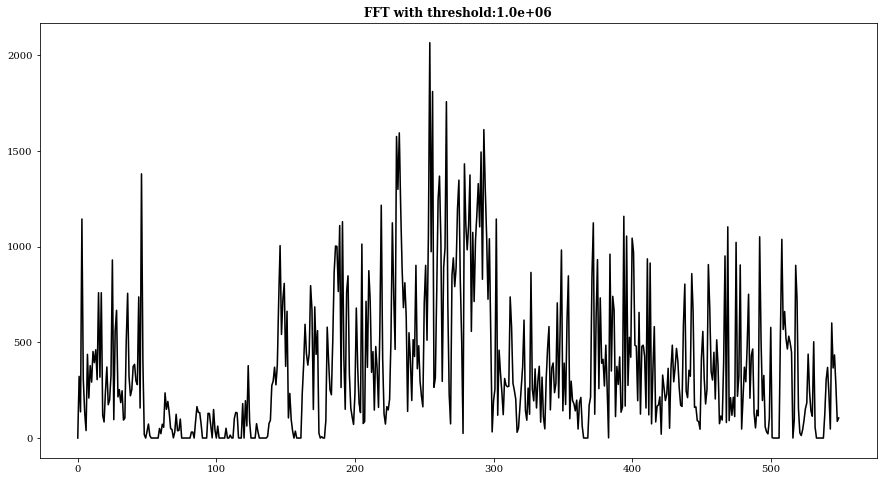

In [18]:
for thresh in [1e2,1e3,1e4,1e5,1e6]:
    plot_fft(thresh)

Here I'd prefer to choose threshold between $1e3$ and $1e4$

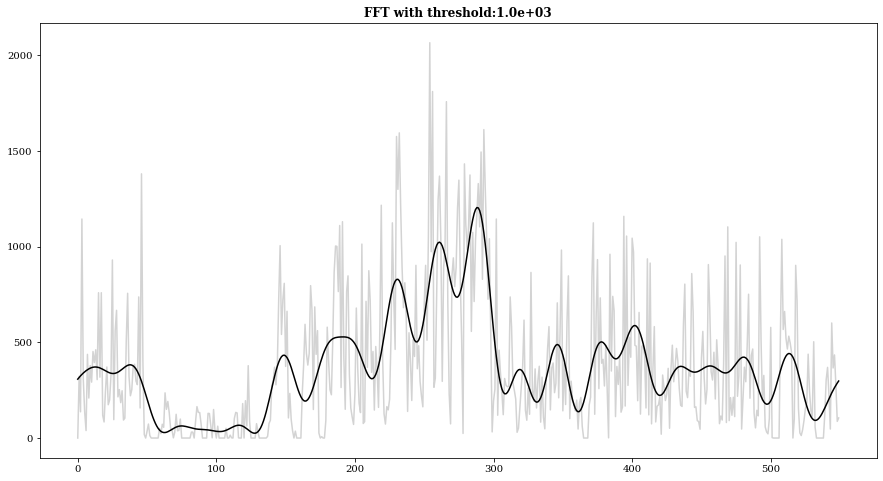

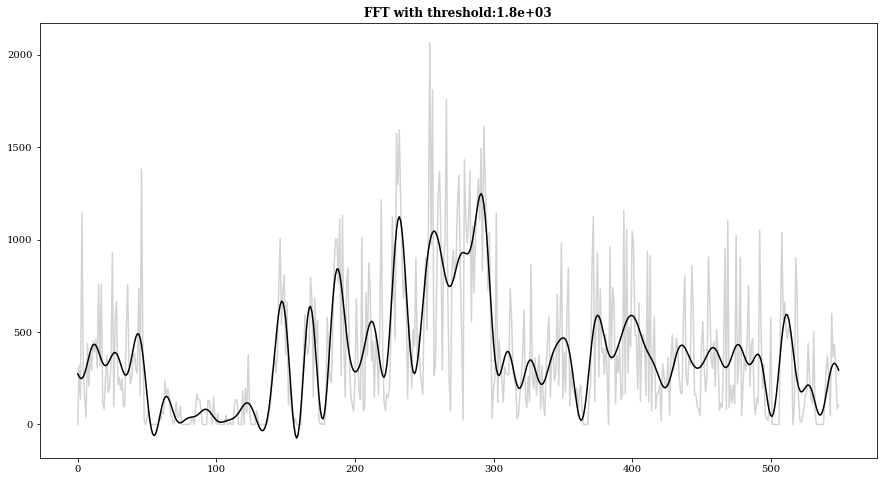

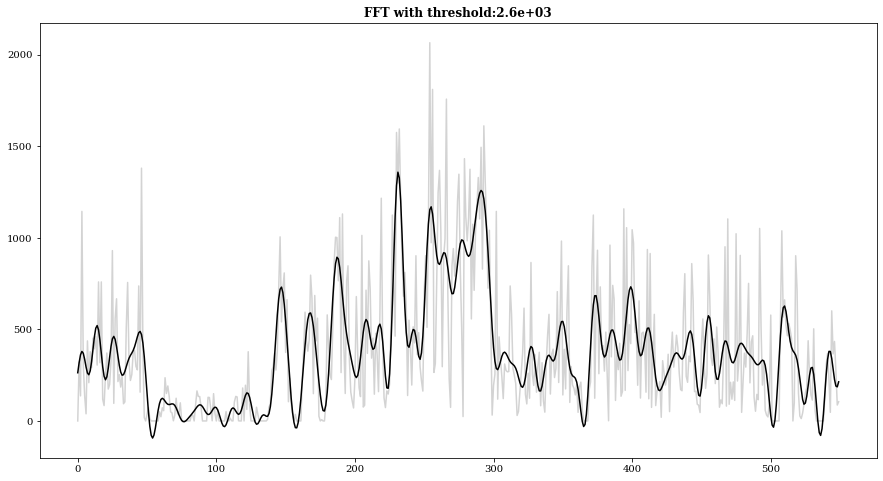

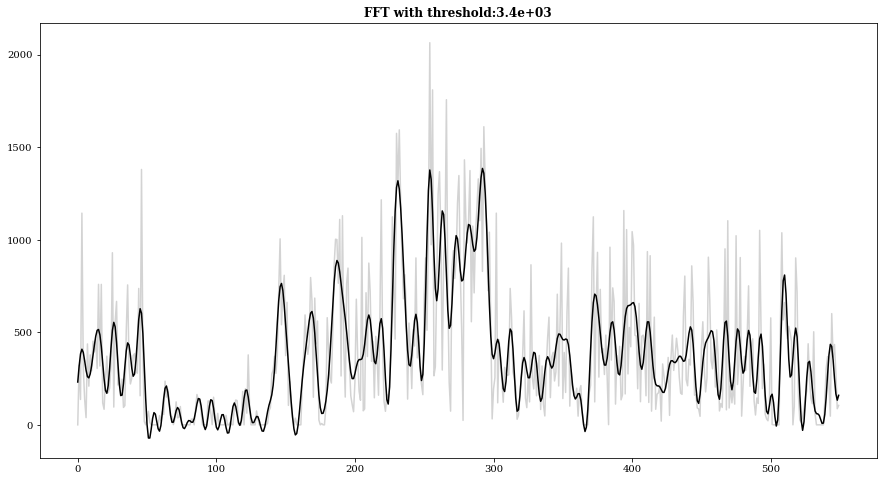

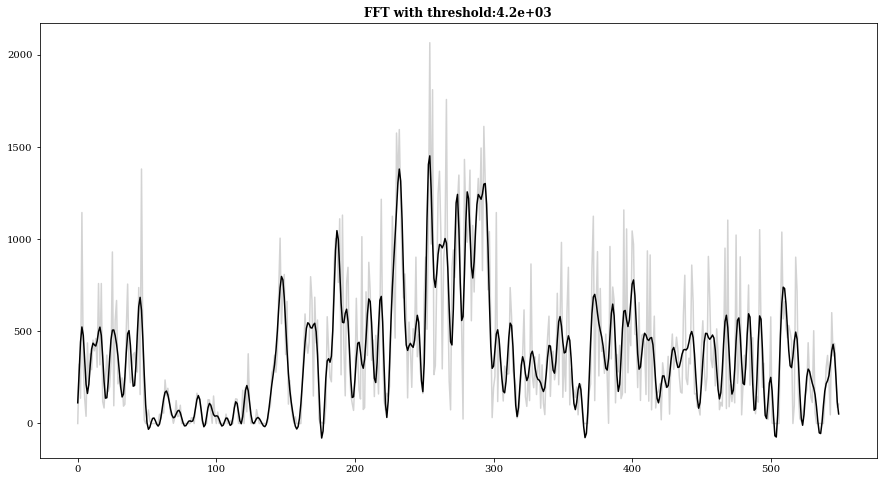

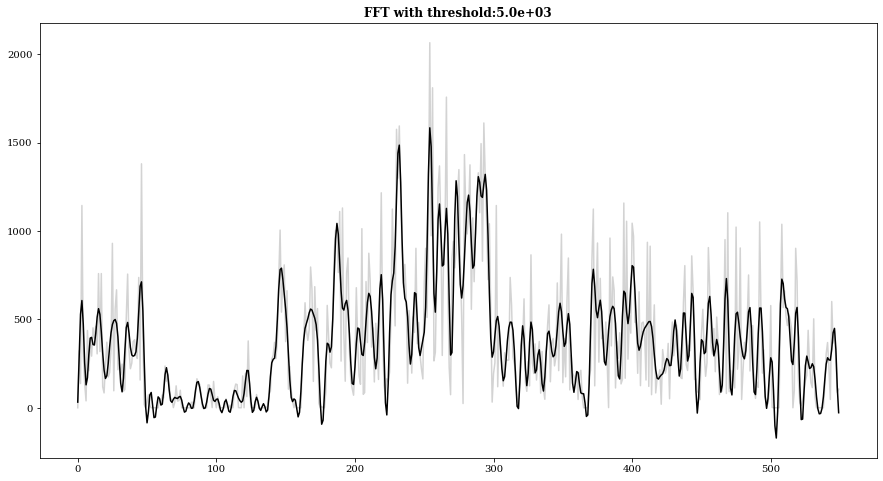

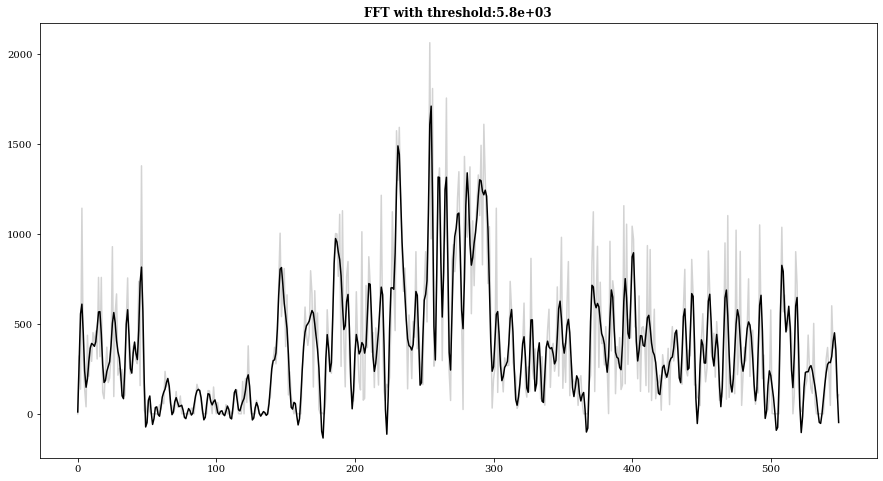

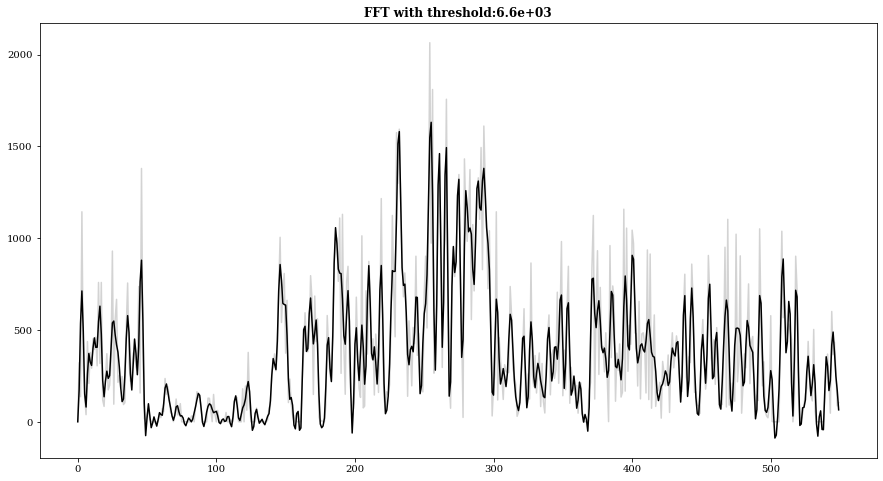

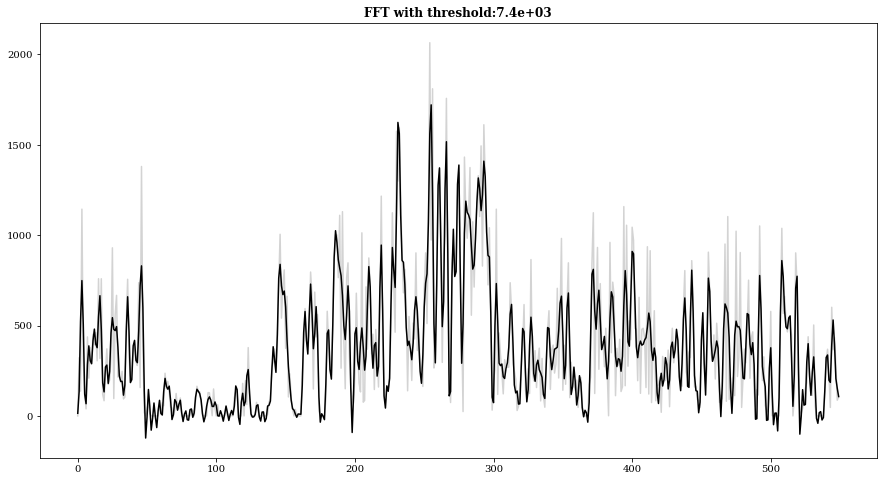

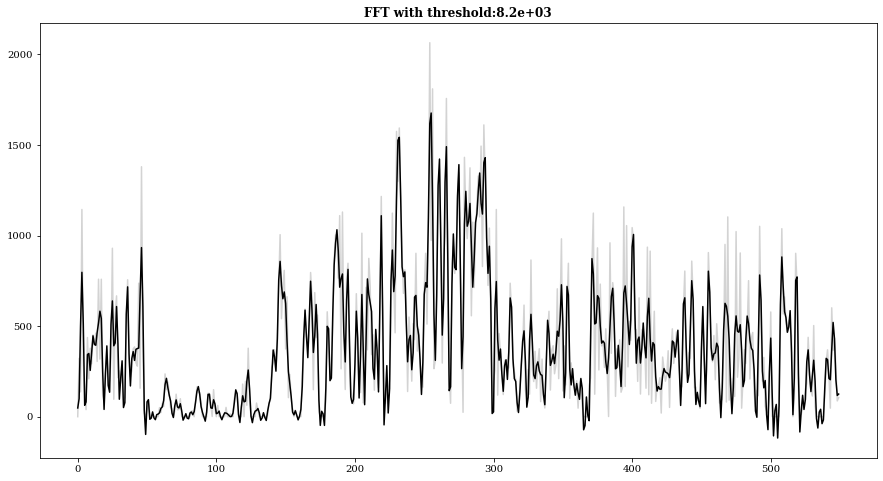

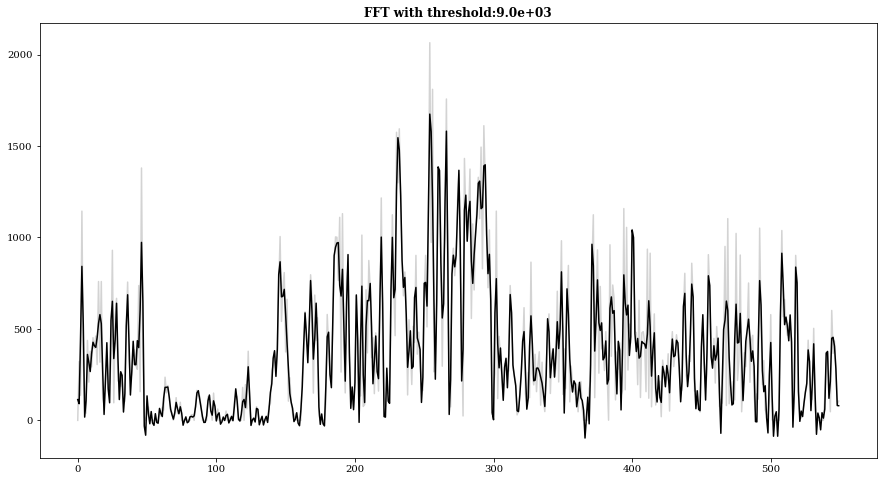

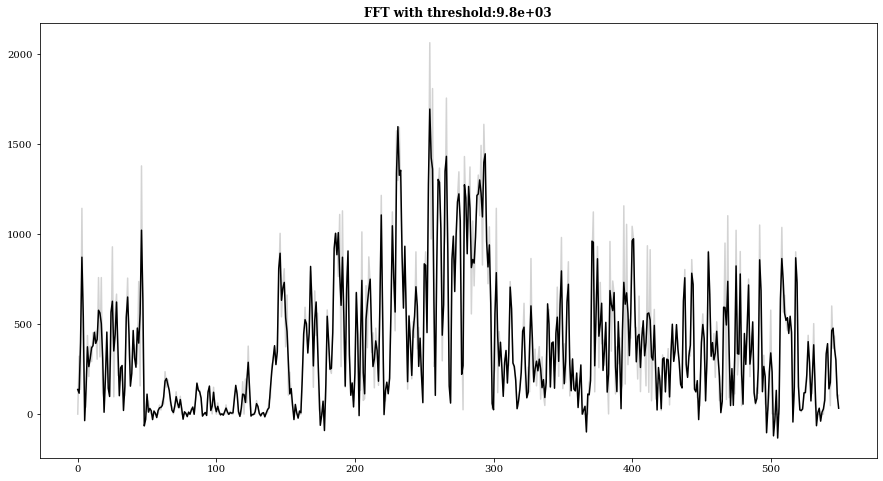

In [19]:
for thresh in np.arange(1e3,1e4,800):
    plot_fft(thresh)

In [24]:
def make_predictions(thresh):
    denoiced_series = low_pass(train.iloc[:, 1],threshold=thresh)

    train_dnoiced = pd.DataFrame(index=train.ds,data=denoiced_series,columns=['y'])
    train_dnoiced.index.name = 'ds'
    train_dnoiced.reset_index(inplace=True)

    m = Prophet()
    m.fit(train_dnoiced)

    predictions = m.predict(test[['ds']])

    y = test.set_index('ds')['y']
    yhat = predictions.set_index('ds')['yhat']

    plot_predictions(y,yhat,metric='MAE')
    m.plot(predictions)
    plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


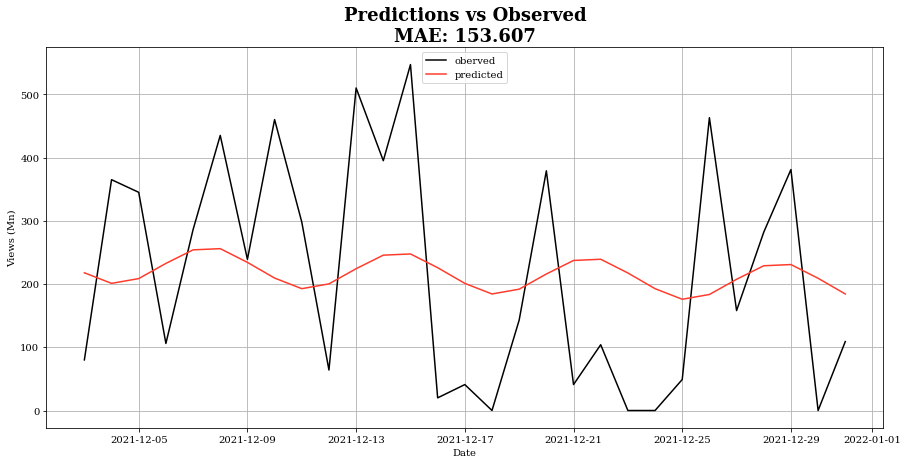

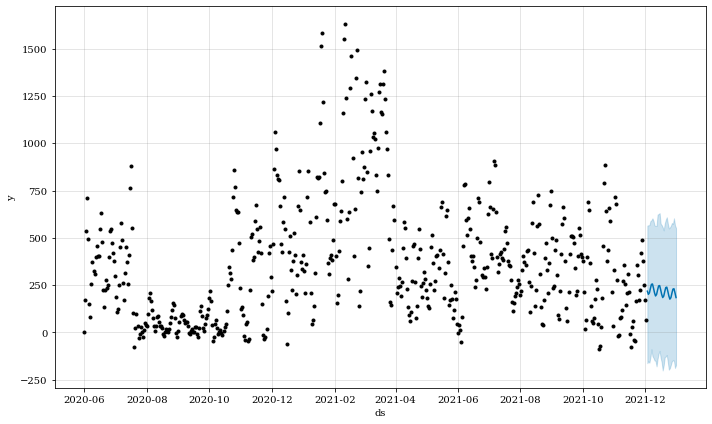

In [25]:
make_predictions(6.6e3)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


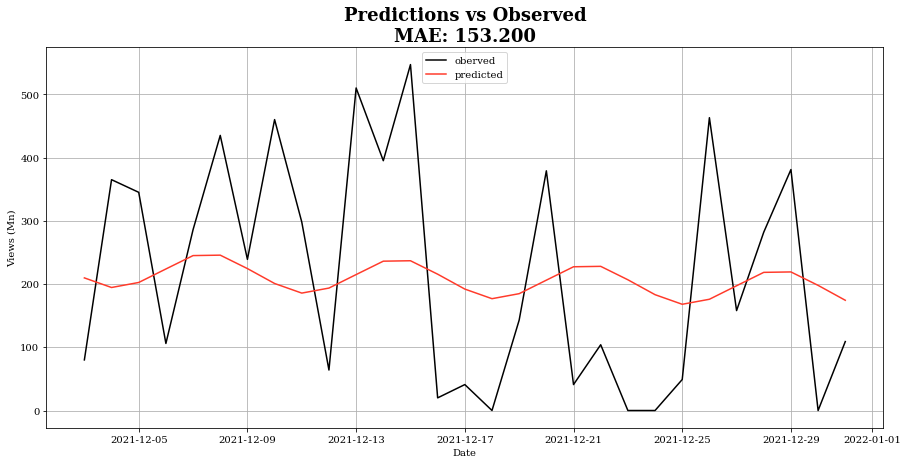

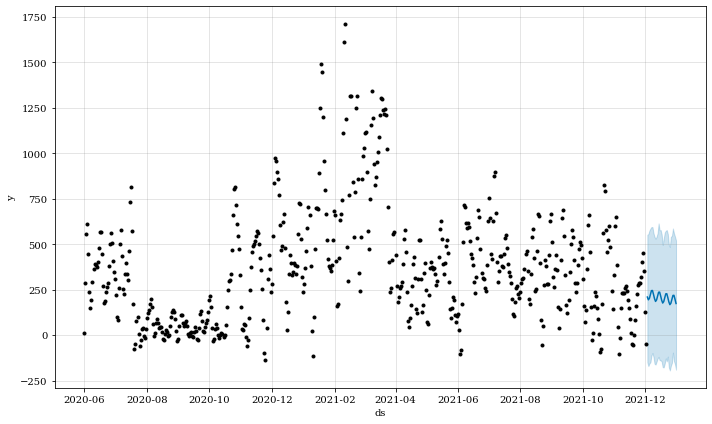

In [26]:
make_predictions(5.8e3)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


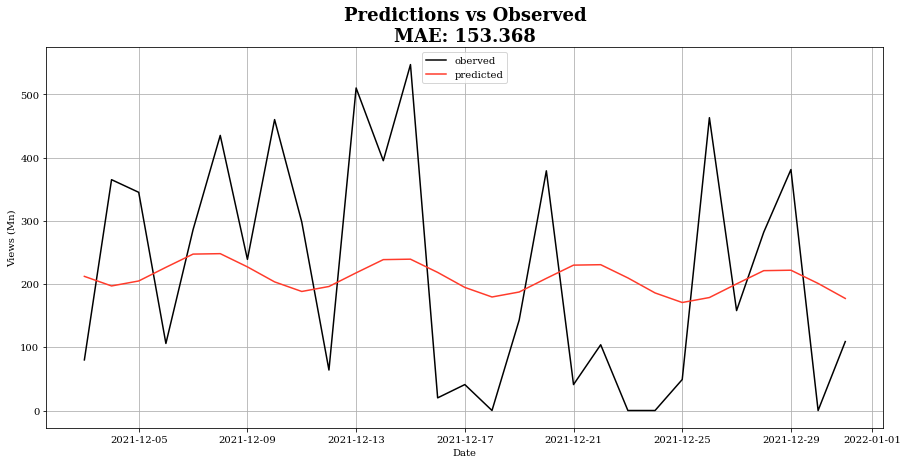

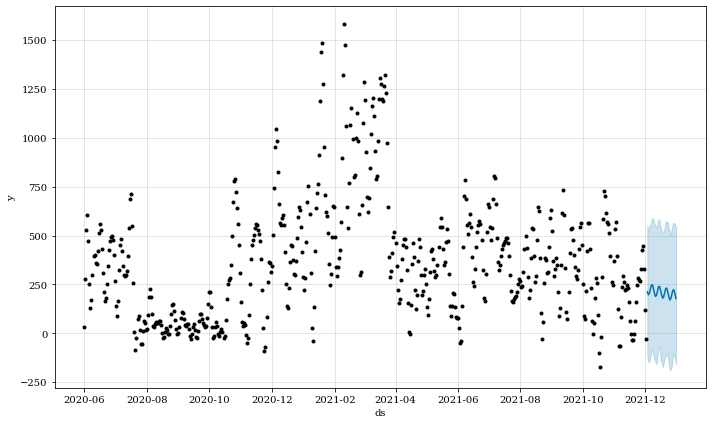

In [27]:
make_predictions(5.0e3)

Even though this example does not works well with denoicing with FFT there are some case we can still use this simple, yet powerfull denoicing method to produce more accurate forecasts.